In [2]:
%pylab inline
import scipy, scipy.misc, scipy.stats

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## How is component reliability measured?

A factory producing hard drives will keep track of a large number of hard drives from a certain model over a few years. The factory will count how many drives failed during that time period and divide by the number of drives to obtain &lambda;, MTBF (or MTTF), F and R.

Some basic formulas and definitions:
- MTBF = mean time between failures (time unit T per failure)
- MTTF = mean time to failure, more or less the same as MTBF
- &lambda; = failures per time unit T (mean over many identical components)
- F = failure rate or probability of failure in time unit T
- R = reliability rate (probability of working in time unit T)

Convertions:

- $\lambda = T / MTBF$
- $F = \lambda / T = 1 / MTBF$
- $R = 1 - F$

T is the time unit over which we calculate, usually years.

E.g.: if component has 0.5 failures per 10 years, then $\lambda = 0.05, MTBF = 200 \mathrm{Years}, F = 0.005, R = 0.995$

That is, the probably of failure within one year is 0.05.

For example, we often see hard drives with MTBF ratings as high as 1.5M hours (~ 160 years, F ~ 0.0063). We smell a rat here, obviously the manufacturer did not track drives for over a decade!
Manufacturers track a large number of drives in a lab under simulated load (which is assumed to mirror reality) for some time then extrapolate the data to large time periods. There are many reports that this does not mirror actual reliability in the field. See [Google's](https://static.googleusercontent.com/external_content/untrusted_dlcp/research.google.com/en//archive/disk_failures.pdf) and [Carnegie Mellon's](http://static.usenix.org/events/fast07/tech/schroeder/schroeder_html/index.html) studies for more on that.


In [9]:
def r_to_mtbf(r):
    return 1 / (1 - r)

r_to_mtbf(0.995)

199.99999999999983

So I have a device with MTBF of 100 years. Does that mean i'm safe for the decade? If my device failed after a year, does that mean the MTBF is wrong?

Of course not. Statistical figures are meaningful in the context of large group (or random selections from such groups), we cannot obtain significant information from a single device.


## [The Hot hand fallacy](https://en.wikipedia.org/wiki/Hot-hand_fallacy)

At the office, I have an old pentium 4 computer running Debian acting as a router/firewall. It has never failed since I installed it 7 years ago. It is as reliable as they come... In fact it has 100% uptime to date!

Have I made a system that can't fail? Does that this mean old pentium 4 computers never fail? Of course not. Let's assume my router has 0.05 yearly failure chance. This was the chance of failure in the first year and it's still the chance of failure this year. Nothing has changed really, I just happened to dodge the bullet several times (it's not a very accurate bullet, thank god) - but nothing guarantees I will keep dodging it.

In other words: **Past performance does not predict future performance**


## [The Gambler's fallacy](https://en.wikipedia.org/wiki/Gambler%27s_fallacy)

We're sitting at the roullete table and so far there have been 7 consecutive "red" results. The chances of winning placing a bet on "red" at the roullette are 0.486 for a single round, we know that the chances of 8 consecutive "red" results are $0.486^{8} \approx 0.003$ so "black" is a sure bet, right?

No. Every round is completely independent of the former round, so although the chances of getting 8-long red streak are 0.003 for any 8 rounds, the chance of getting red in *this* (or any) round is 0.486.

## Bathtub curve

Of course, the reliability of components does not remain the same over time, as illustrated by the famous ["bathtub curve"](https://en.wikipedia.org/wiki/Bathtub_curve)

![Bathtub curve](http://www.weibull.com/hotwire/issue21/ht21_1.gif)

This makes sense for hardware, but what about software? although "infant mortality" does occur in a way (many bugs are found very early) software does not "wear out". Or does it? as the complexity of the code grows, we often see a rise in the number of bugs. I'm not suggesting all software can be modeled by the bathtub curve, but it's definitely worth thinking about.

For simplicity, we will mostly treat the "constant" part of the curve.

## Serial reliability

For components connected in series, that is, a single failure can take out the system, the total reliability of the system is:

$\lambda_{total} = \sum_i \lambda_i , R_{total} = \prod_{i} R_i$

This means that $R_{total} < min(R_i)$ Total reliability is _lower_ then the reliability of the worst component. 

Suppose we have a 3 components system with reliabilities $R_1 = 0.95, R_2 = 0.99 R_3 = 0.995$; The overall reliability of the system is $R_{total} = 0.9357975$ which is indeed worse the 0.95, the reliabiliy of $R_1$ our worst component. Now, which component should we invest in? suppose we can improve (reduce) the failure rate of single component by a factor of 10 at equal cost, which shall we choose?

|improved|R1|R2|R3|Rtotal|improvement factor|
|-|-|-|-|-|
|-|0.95|0.99|0.995|0.9357975|-|
|R1|0.995|0.99|0.995|0.98012475|3.21x|
|R2|0.95|0.999|0.995|0.94430475|1.15x|
|R3|0.95|0.99|0.9995|0.94|1.07x|

We can see that the best ROI comes from improving the worst component and that improving the most reliable component achieves almost nothing.

## Parallel reliability (redundancy)

The reliability of a parallel system can be computed by the formula:
$R_{total} = \sum_{i=0}^{k} \binom{n}{k} R^{i} F^{n-i}$

For simplicity we assume identical components.


It's important to note that &lambda; is a statistical mean (average) of failures of many components; If you operate a single such component with $F = 0.05$ for 10 years you may have 0 failures or a failure within the first year; in fact, there's a $0.95^{10} \approx 0.6$ chance of a component surviving 10 years. 
Over _n_ components, the of probability of having _k_ failures follows a binomial distribution. 

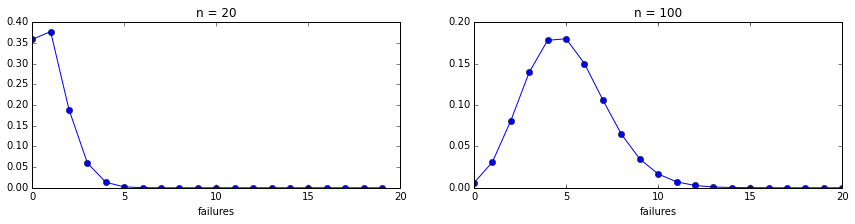

In [4]:
n_components1, n_components2 = 20, 100
f = 0.05
k_failures_vec1 = arange(0, n_components1, 1)
k_failures_vec2 = arange(0, n_components2, 1)

pmf1 = scipy.stats.binom.pmf(k_failures_vec1, n_components1, f)
pmf2 = scipy.stats.binom.pmf(k_failures_vec2, n_components2, f)
ax1 = plt.subplot(121)
ax1.set_xlabel('failures')
plt.title('Probability mass function (binomial)')
ax1.plot(k_failures_vec1, pmf1, marker='o')
ax1.set_title('n = 20')
ax2 = plt.subplot(122)
ax2.set_xlabel('failures')
ax2.set_xticks(arange(0, 100, 5), minor=True)
ax2.plot(k_failures_vec2, pmf2, marker='o')
ax2.set_title('n = 100')
ax2.set_xlim(0, 20)
plt.subplots_adjust(top=0.7, right=2)

That is, over many systems composed of _n_ components with $F = 0.05$ many (~ 40%) will have 1 failure per year, about 18% will have 2 failures and so on. This shows that with more components we have higher chance of multiple failures. Which is why systems with more components need to be more redundant in absolute numbers. This is also why you want to fix the failed component before another failure occurs... 

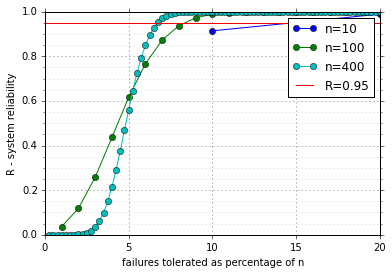

In [5]:
def r_prob(r, n, k):
    """The reliability of parallel system with n component that can tolerate up to k failures
    """
    return sum([scipy.misc.comb(n, i)*(1-r)**i*r**(n-i) for i in range(0,k+1)])

vec_r_prob = np.vectorize(r_prob)

ax = plt.subplot(111)
r = 0.95

for n, color in [(10, 'b'), (100, 'g'), (400, 'c')]:
    x = np.linspace(1, n, n, dtype='int')
    ax.plot(x / float(n) * 100, vec_r_prob(r, n, x), label='n=%d' % n, color=color, marker='o')

# plot formatting stuff, not really interesting
ax.axhline(r, color='r', label='R=%0.2f' % r)
ax.legend()
ax.set_xlabel('failures tolerated as percentage of n')
ax.set_ylabel('R - system reliability')
ax.set_yticks(np.arange(0, 1.2, 0.2))
ax.set_yticks(np.arange(0, 1.05, 0.05), minor=True)
ax.set_xticks(np.arange(0, 101, 5), minor=True)
ax.tick_params(which = 'both', direction = 'out')
ax.set_ylim(0, 1.0)
ax.set_xlim(0, 20)
ax.grid(which='major', alpha=0.7)
ax.grid(which='minor', alpha=0.3)

From the above graph we can see that as n grows we need smaller redundancy to achieve the same reliability. With 10 machines we need 20% redundancy to be more reliable than a single node, with 100 only 9% and with 400 nodes only 6% redudancy.
We can also see that with small redudancy reliability actually *decreases*, because there are more options for failure.

In [6]:
for r, n, k in [(0.95, 10, 2), (0.99, 10, 2)]:
    r_total = r_prob(r, n, k)
    print "r_comp=%.2f, mtbf_comp=%d, r_total=%.4f, mtbf_total=%d" % (r, r_to_mtbf(r), r_total, r_to_mtbf(r_total))


r_comp=0.95, mtbf_comp=19, r_total=0.9885, mtbf_total=86
r_comp=0.99, mtbf_comp=99, r_total=0.9999, mtbf_total=8783


From this we see that redundancy acts as a multiplier on component MTBF - improving component MTBF by a factor of 5 improves total MTBF by a factor of 100!
So redudancy will have higher ROI if your components are already reliable.

## Nagios (and derivatives) monitoring

Nagios services transition from OK to HARD CRITICAL if *max_check_attempts* are over the threshold. Suppose we are monitoring a web service that is experiencing a failure and has 40% error rate.
The chances of detecting failure and transitioning to CRITICAL are $P = 0.4^4 \approx 0.026$. That's pretty low!
The graph below shows the probability of not getting at least one alert, over time. Even after 1.5 hours there's still ~ 9.9% chance of not getting any alert!

**Note**: Nagios in fact uses a _sliding window_ which has different probabilities, we used a simplistic model to make the point. Sliding windows have better statistical behavior so you will get alerts earlier than predicted by this model, yet still with very small probabilities.
Also, in reality you are more likely to experience low or extremely high error rates on failures, 40% is a bit rare; In the case of low error rates you are not likely to recieve any notification from Nagios 

P(critical)=0.026


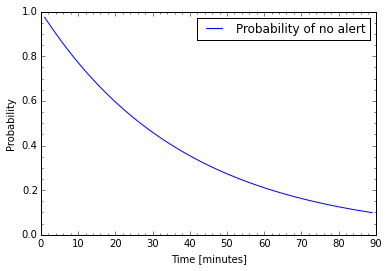

In [54]:
p=0.4
p_crit = p**4
print "P(critical)=%.3f" % p_crit
p_ok = 1 - p_crit
p_no_alert = [p_ok**n for n in range(1, 90)]

plt.plot(range(1,90), p_no_alert, label='Probability of no alert')
plt.minorticks_on()
plt.xlabel("Time [minutes]")
plt.ylabel("Probability")
plt.legend()

## Correlated failures and Bayes theorem

So far, we've assumed events (failures) are indepdent of each other. In general, this is not true. There are many reasons for correlated failures:

- shared code
- shared workload (common abuse profile)
- shared infrastructure (network, power, databases, etc.)

In a complex system it is sometimes not obvious that components are coupled, for example the load balancer in front of application servers can cause coupling between application servers without experiencing a failure itself.

For conditional probaility, that is, the probability of A occuring given that B has occurred we have the Bayes Theorem: $P(A|B) = P(B|A) \cdot P(A) / P(B)$

### [The base rate fallacy](https://en.wikipedia.org/wiki/Base_rate_fallacy)

In an active standby cluster, if the master fails the failover controller detects the failure with 100% probability and cat fail over to the standby. However, it does have a small number of false positives, about 2%. Database relibility is 99.9%.

One day, the controller detects a failure. What is the probability the master has really failed? should we activate  the standby? If you are inclined to say 98% as the controller only has 2% false positives, then you've fallen for the _base rate fallacy_. The actual figure is (computing by bayes theorem):

Event D: master failure detected by controller 

$P(master\_failed|D) = P(D|master\_failed)P(master\_failed)/P(D) \\
P(D) = P(D|master\_failed)P(master\_failed) + P(D|master\_ok)P(master\_ok)$

We know that

$P(master\_failed) = 0.001, P(master\_ok) = 0.999, P(D|master\_failed) = 1, P(D|master\_ok) = 0.02$
So:

$P(D) = 0.001 + 0.02 \cdot 0.999 = 0.02098$

Assigning in the first equation we get:

$P(D|master\_failed) = 0.001 / 0.2098 \approx 0.0048$

That is, a little less then 0.5%!!! that actually very low!

The reason for this, is the base rate - in 1000 samples the controller will detect 1 database failure and 20 false positives, so the odds are 20:1 this a false results is bogus.

In [8]:
q=0.001 # master failure probability
r=0.999 # master reliability
fp=0.02 # false positive probability
p_d = q + fp*r
p_d_master_failed = q/p_d
p_d_master_failed

0.047664442326024785

If all failovers to standby were error free this would not be a problem. But unfortunately failovers can often cause problems, e.g. slave crashing due to cold start or the dreaded split brain. In 2012, [Github had a severe outage](https://github.com/blog/1261-github-availability-this-week) caused by 2 consecutive false positive failovers in their MySQL cluster (well, it was more complicated than that; in complex systems component failure is only the trigger in quirky chain of event).

This means we need to have extremly small number of false positive in automatic failovers or alternatively make sure failovers cannot cause problems - which is why active-active systems are preferred.